# <span style="color:#336699">Agrupamento de músicas utilizando redes SOM</span>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Autor: Flávio Belizário da Silva Mota
    <br/><br/>
    Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contato: <a href="mailto:flavio.belizario.mota@gmail.com">flavio.belizario.mota@gmail.com</a>
    <br/>
    Professor: Marcos Goncalves Quiles
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Objetivo.</b> Esse caderno Jupyter tem como objetivo apresentar o uso do SOM na tarefa de agrupamento de músicas, como parte do Projeto Final da disciplina de Neurocomputação (CAP-351). Os dados utilizados são provenientes do conjunto de dados produzido pelo estudo de Misael et al. 2020, intitulado Temporal Analysis and Visualisation of Music.
</div>

<br/>
<div style="text-align: center;font-size: 90%;">
    <b>Os dados podem ser encontrados em:</b>
    <div style="margin-left: 10px; margin-right: 10px">
    https://data.mendeley.com/datasets/3t9vbwxgr5/3
    </div>
</div>

## Importando bibliotecas
<hr style="border:2px solid #0077b9;">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from minisom import MiniSom
from numpy.random import seed
seed(42)

## Funções utilitárias para plotagem de gráficos
<hr style="border:2px solid #0077b9;">

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def umatrix(som_model, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing Map U-Matrix
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        matplotlib.figure.Figure: grid figure
    """   

    distance_map = som_model.distance_map()
    
    if transpose:
        distance_map = distance_map.T[::-1]

    im = plt.imshow(distance_map, **kwargs)
    if use_colorbar: plt.colorbar(im)
    plt.savefig("u_matrix.png")

def hitmap(som_model, data, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing map hitmap
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional array para estimular os neurônios
        e gerar o mapa de ativação
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        transpose (bool): Transpoe e inverte a matriz
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """     
    frequencies = som_model.activation_response(data).astype(int)
    
    if transpose:
        frequencies = frequencies.T[::-1]

    im = plt.imshow(frequencies, **kwargs)
    if use_colorbar: plt.colorbar(im)
    
    for (i, j), value in np.ndenumerate(frequencies):
        plt.text(j, i, value, verticalalignment='center', 
                              horizontalalignment='center')
    plt.savefig("hitmap.png")

def umatrix_labeled(som_model, 
                    data, 
                    labels, 
                    colors, 
                    markers, 
                    use_colorbar=True,
                    plot_lbl_args=None,
                    **kwargs):
    """Plot U-Matrix com label em cada neurônio
    
    Args:
        som_model (minisom.MiniSom): MiniSom Model
        
        data (np.ndarray): n-dimensional array para estimular os neurônios
        e gerar o mapa de ativação
        
        labels (np.ndarray): 1-dimensional array com as labels. precisa ser valores 
        inteiros discretos (e. g. 0, 1, 2, ...)
        
        colors (list): Cores para cada uma das classes (Considera a posição com o label da classe)
        (e. g. classe 1 será a posição 1 desta lista)
        
        markers (list): Markers para cada uma das classes (Considera a posição)
        (e. g. classe 1 será a posição 1 desta lista)
        
        use_colorbar (bool): Flag para ativar colorbar no plot
        
        plot_lbl_args (dict): Parâmetros para a função matplotlib.pyplot.plot utilizada no plot
        das labels
        
        kwargs (dict): Parâmetros para a função to matplotlib.pyplot.imshow
    Returns:
        None
    """
    
    if not plot_lbl_args:
        plot_lbl_args = {
            'markerfacecolor': 'None',
            'markersize': 6,
            'markeredgewidth': 1
        }
    
    im = plt.imshow(som_model.distance_map(), **kwargs)
    if use_colorbar: plt.colorbar(im)
    
    for idx, de in enumerate(data):
        label_idx = labels[idx] - 1
        
        winner = som_model.winner(de)
        plt.plot(winner[1], winner[0], 
                 markers[label_idx], 
                 markeredgecolor=colors[label_idx],
                 **plot_lbl_args)
    plt.savefig("u_matrix_labeled.png")

## Carregando os dados
<hr style="border:2px solid #0077b9;">

In [3]:
df = pd.read_csv('music_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28372 entries, 0 to 28371
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                28372 non-null  int64  
 1   artist_name               28372 non-null  object 
 2   track_name                28372 non-null  object 
 3   release_date              28372 non-null  int64  
 4   genre                     28372 non-null  object 
 5   lyrics                    28372 non-null  object 
 6   len                       28372 non-null  int64  
 7   dating                    28372 non-null  float64
 8   violence                  28372 non-null  float64
 9   world/life                28372 non-null  float64
 10  night/time                28372 non-null  float64
 11  shake the audience        28372 non-null  float64
 12  family/gospel             28372 non-null  float64
 13  romantic                  28372 non-null  float64
 14  commun

### Analisando as colunas

In [4]:
df.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre',
       'lyrics', 'len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability',
       'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
       'topic', 'age'],
      dtype='object')

### Contando os gêneros da base

In [5]:
df['genre'].value_counts()

pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: genre, dtype: int64

### Definindo os atributos

In [6]:
colunas_musicais = ['acousticness', 'danceability', 'loudness', 
                    'instrumentalness', 'valence', 'energy']

colunas_topicos = ['dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings']

colunas = colunas_musicais + colunas_topicos

### Criando a máscara dos gêneros rock e reggae e plotando a distribuição

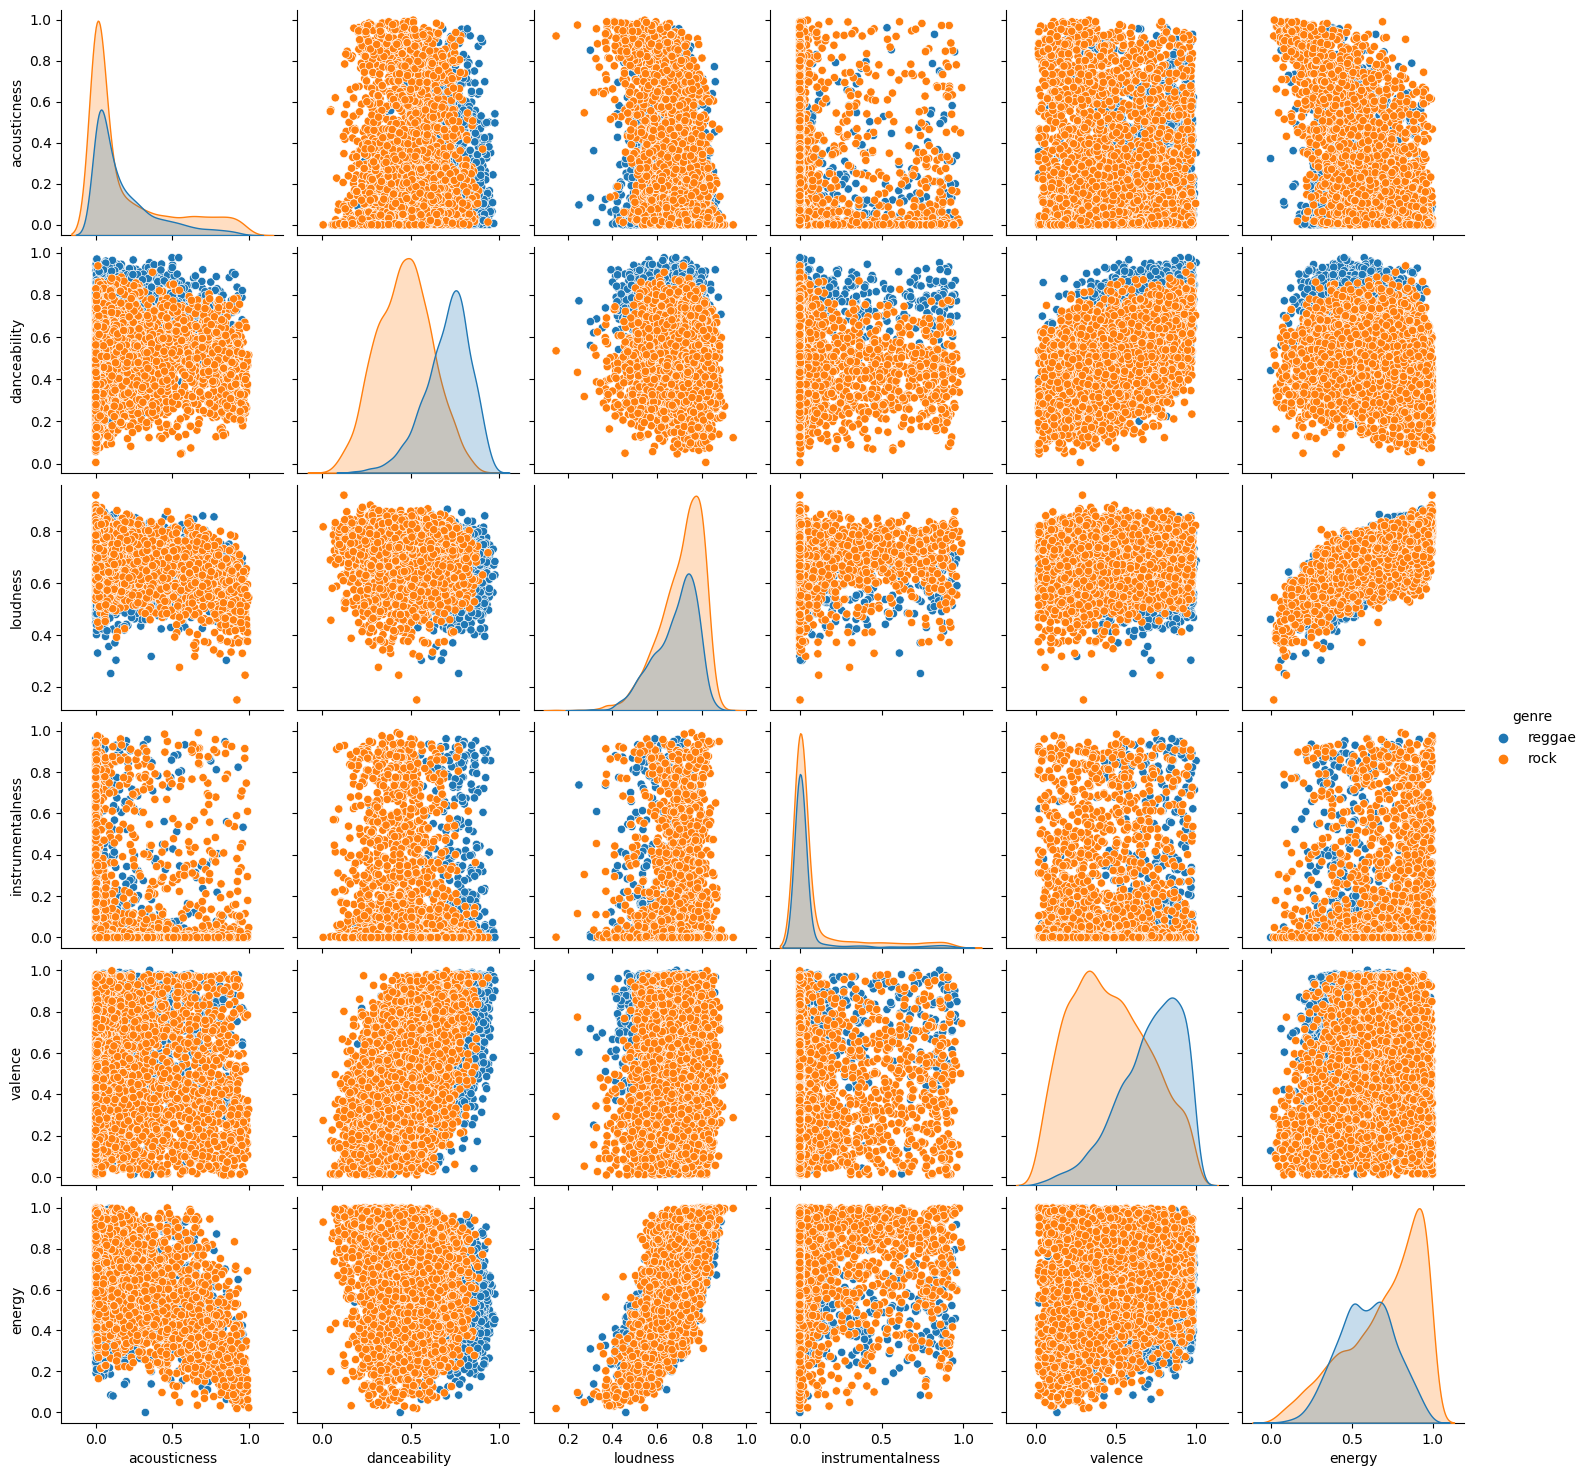

In [33]:
mascara = (df['genre'] == 'rock') | (df['genre'] == 'reggae')
df_genero = df.loc[mascara]
sns.pairplot(df_genero[colunas_musicais + ['genre']], hue = 'genre')
plt.savefig("distribuicao_dados.png")
plt.show()

### Definindo a amostra do dado

In [7]:
mascara_genero = (df['genre'] == 'reggae') | (df['genre'] == 'rock')
df_sample = df.loc[mascara_genero].reset_index(drop=True)

In [8]:
le = LabelEncoder()
df_sample['genre_grupo'] = le.fit_transform(df_sample['genre'])
y = df_sample['genre_grupo']

## Experimento 1 - Atributos Musicais

In [9]:
X_feat = df_sample[colunas_musicais]
X_feat = X_feat.values

In [10]:
X_feat.shape

(6532, 6)

In [12]:
m = 5
n = 5
max_iter = 10000
som_1 = MiniSom(m, n, X_feat.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som_1.train(X_feat, max_iter)
q = som_1.quantization_error(X_feat)
t = som_1.topographic_error(X_feat)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 375 ms
Wall time: 375 ms
Erro de quantização:  0.22520361643211756
Erro de topografia:  0.21187997550520515


In [13]:
m = 10
n = 10
max_iter = 10000
som_2 = MiniSom(m, n, X_feat.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som_2.train(X_feat, max_iter)
q = som_2.quantization_error(X_feat)
t = som_2.topographic_error(X_feat)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 469 ms
Wall time: 463 ms
Erro de quantização:  0.15698107605987996
Erro de topografia:  0.35287813839559096


In [14]:
m = 25
n = 25
max_iter = 10000
som_3 = MiniSom(m, n, X_feat.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som_3.train(X_feat, max_iter)
q = som_3.quantization_error(X_feat)
t = som_3.topographic_error(X_feat)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.09 s
Wall time: 1.09 s
Erro de quantização:  0.12157415425824643
Erro de topografia:  0.32731169626454376


In [26]:
m = 25
n = 25
max_iter = 10000
som = MiniSom(m, n, X_feat.shape[1], sigma=1.8, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som.train(X_feat, max_iter)
q = som.quantization_error(X_feat)
t = som.topographic_error(X_feat)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.61 s
Wall time: 1.62 s
Erro de quantização:  0.11455312206164228
Erro de topografia:  0.12568891610532762


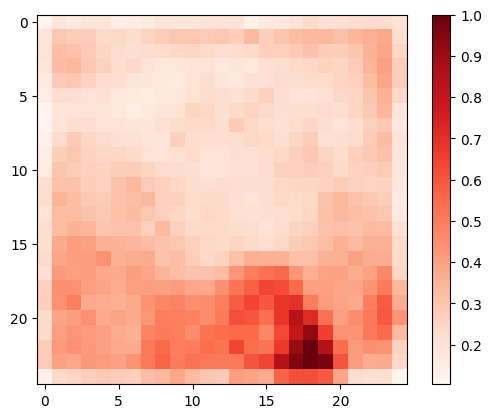

In [27]:
umatrix(som, cmap='Reds')

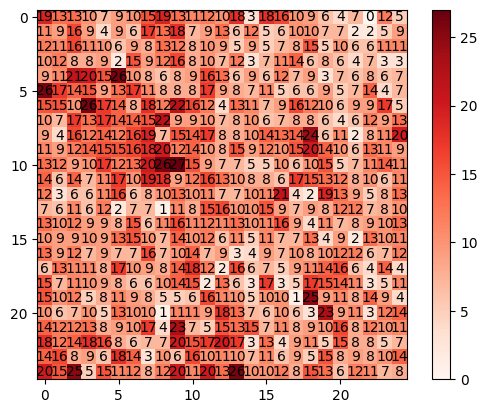

In [28]:
hitmap(som, X_feat, cmap='Reds')

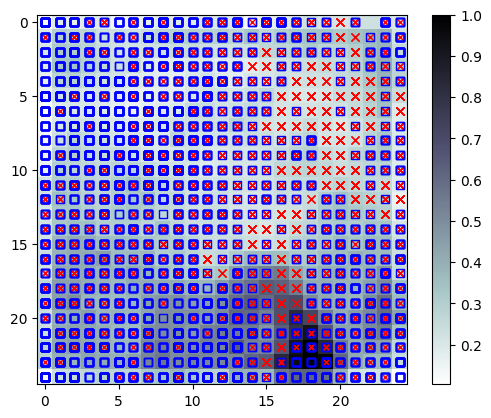

In [29]:
colors = ['blue', 'red']
markers = ['s','x']
umatrix_labeled(som, X_feat, y, colors, markers, cmap = 'bone_r')

## Experimento 2 - Atributos baseados em tópicos

In [16]:
X_feat_t = df_sample[colunas_topicos]
X_feat_t = X_feat_t.values
X_feat_t.shape

(6532, 16)

In [17]:
m = 5
n = 5
max_iter = 10000
som2_1 = MiniSom(m, n, X_feat_t.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som2_1.train(X_feat_t, max_iter)
q = som2_1.quantization_error(X_feat_t)
t = som2_1.topographic_error(X_feat_t)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 391 ms
Wall time: 387 ms
Erro de quantização:  0.232876749929541
Erro de topografia:  0.30557256582976117


In [18]:
m = 10
n = 10
max_iter = 10000
som2_2 = MiniSom(m, n, X_feat_t.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som2_2.train(X_feat_t, max_iter)
q = som2_2.quantization_error(X_feat_t)
t = som2_2.topographic_error(X_feat_t)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 500 ms
Wall time: 497 ms
Erro de quantização:  0.18773208087881668
Erro de topografia:  0.36298224127372936


In [19]:
m = 25
n = 25
max_iter = 10000
som2_3 = MiniSom(m, n, X_feat_t.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som2_3.train(X_feat_t, max_iter)
q = som2_3.quantization_error(X_feat_t)
t = som2_3.topographic_error(X_feat_t)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.31 s
Wall time: 1.32 s
Erro de quantização:  0.16656902334461418
Erro de topografia:  0.37660747091243113


In [20]:
m = 25
n = 25
max_iter = 10000
som2 = MiniSom(m, n, X_feat_t.shape[1], sigma=2.1, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som2.train(X_feat_t, max_iter)
q = som2.quantization_error(X_feat_t)
t = som2.topographic_error(X_feat_t)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.23 s
Wall time: 1.25 s
Erro de quantização:  0.1595483201168167
Erro de topografia:  0.1333435394978567


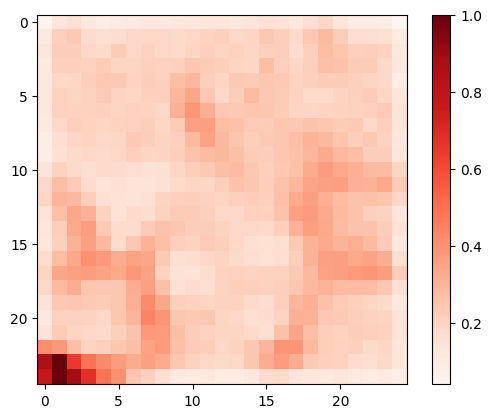

In [127]:
umatrix(som2, cmap='Reds')

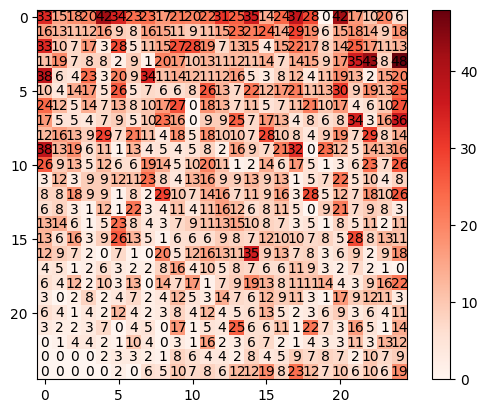

In [128]:
hitmap(som2, X_feat_t, cmap='Reds')

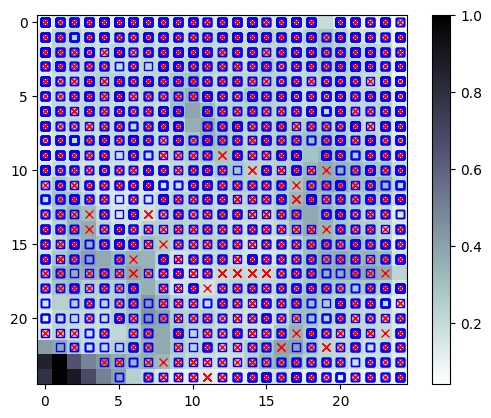

In [178]:
colors = ['blue', 'red']
markers = ['s','x']
umatrix_labeled(som2, X_feat_t, y, colors, markers, cmap = 'bone_r')

In [ ]:
m


In [21]:
X_feat_c = df_sample[colunas]
X_feat_c = X_feat_c.values
X_feat_c.shape

(6532, 22)

In [22]:
m = 5
n = 5
max_iter = 10000
som3_1 = MiniSom(m, n, X_feat_c.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som3_1.train(X_feat_c, max_iter)
q = som3_1.quantization_error(X_feat_c)
t = som3_1.topographic_error(X_feat_c)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 453 ms
Wall time: 457 ms
Erro de quantização:  0.4475523443139928
Erro de topografia:  0.5081139007960809


In [23]:
m = 10
n = 10
max_iter = 10000
som3_2 = MiniSom(m, n, X_feat_c.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som3_2.train(X_feat_c, max_iter)
q = som3_2.quantization_error(X_feat_c)
t = som3_2.topographic_error(X_feat_c)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 531 ms
Wall time: 530 ms
Erro de quantização:  0.37581818945614087
Erro de topografia:  0.42835272504592775


In [24]:
m = 25
n = 25
max_iter = 10000
som3_3 = MiniSom(m, n, X_feat_c.shape[1], sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som3_3.train(X_feat_c, max_iter)
q = som3_3.quantization_error(X_feat_c)
t = som3_3.topographic_error(X_feat_c)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.5 s
Wall time: 1.48 s
Erro de quantização:  0.3471208847356007
Erro de topografia:  0.4127372933251684


In [149]:
m = 25
n = 25
max_iter = 10000
som3 = MiniSom(m, n, X_feat_c.shape[1], sigma=2.0, learning_rate=0.3, neighborhood_function='gaussian', random_seed=42)
%time som3.train(X_feat_c, max_iter)
q = som3.quantization_error(X_feat_c)
t = som3.topographic_error(X_feat_c)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.59 s
Wall time: 1.6 s
Erro de quantização:  0.32860910729749776
Erro de topografia:  0.12431108389467238


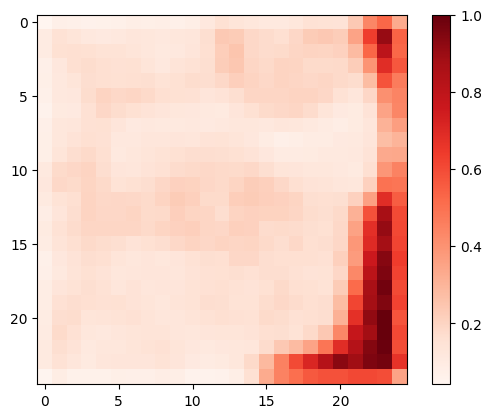

In [150]:
umatrix(som3, cmap='Reds')

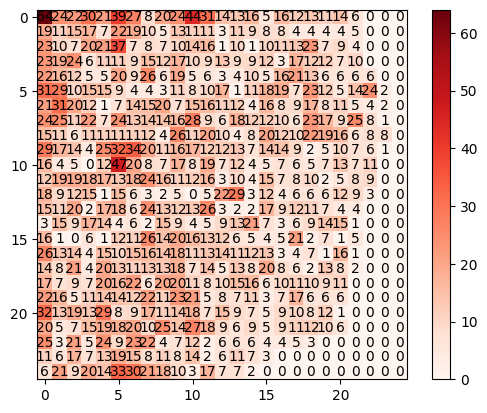

In [151]:
hitmap(som3, X_feat_c, cmap='Reds')

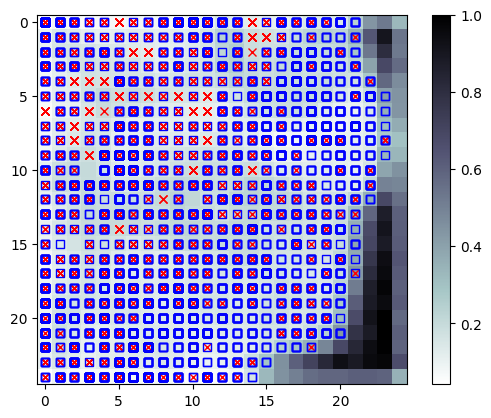

In [179]:
colors = ['blue', 'red']
markers = ['s','x']
umatrix_labeled(som3, X_feat_c, y, colors, markers, cmap = 'bone_r')

In [155]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_feat, y)
clf.feature_importances_

array([0.11369703, 0.34451797, 0.0958393 , 0.08910593, 0.20798081,
       0.14885897])

In [157]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_feat)

In [158]:
X_new.shape

(6532, 2)

In [170]:
m = 25
n = 25
max_iter = 10000
som4 = MiniSom(m, n, X_new.shape[1], sigma=2.1, learning_rate=0.5, neighborhood_function='gaussian', random_seed=42)
%time som4.train(X_new, max_iter)
q = som4.quantization_error(X_new)
t = som4.topographic_error(X_new)
print('Erro de quantização: ', q)
print('Erro de topografia: ', t)

CPU times: total: 1.14 s
Wall time: 1.13 s
Erro de quantização:  0.014779284851380681
Erro de topografia:  0.015462339252908757


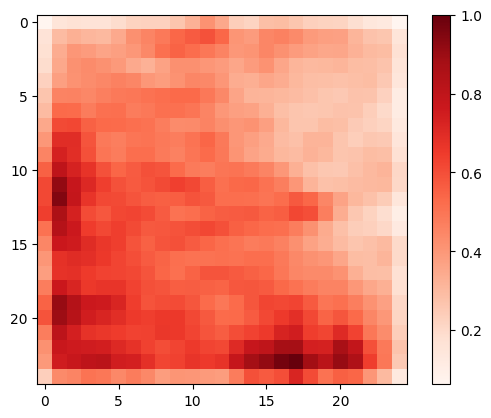

In [171]:
umatrix(som4, cmap='Reds')

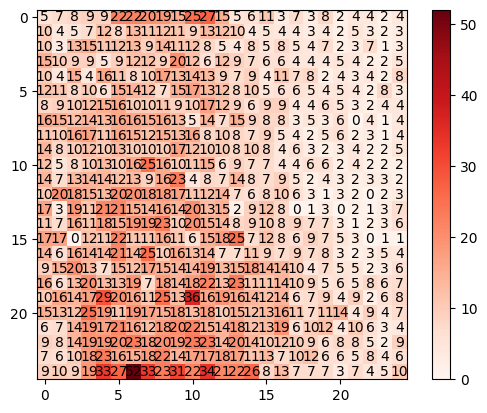

In [172]:
hitmap(som4, X_new, cmap='Reds')

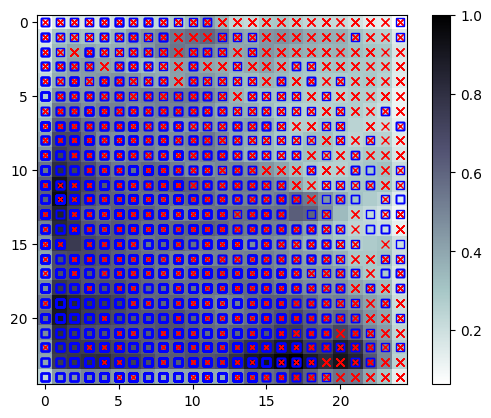

In [173]:
colors = ['blue', 'red']
markers = ['s','x']
umatrix_labeled(som4, X_new, y, colors, markers, cmap = 'bone_r')